In [23]:
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from gmr import GMM
import pandas as pd
import json
from synthBN.bn_generator import BNGenerator
import seaborn as sns

In [24]:
X, _ = make_blobs(n_samples=1000, centers=1, n_features=5, random_state=0)

In [25]:
gmm = GaussianMixture(n_components=3).fit(X)


In [26]:
df = pd.DataFrame(X)

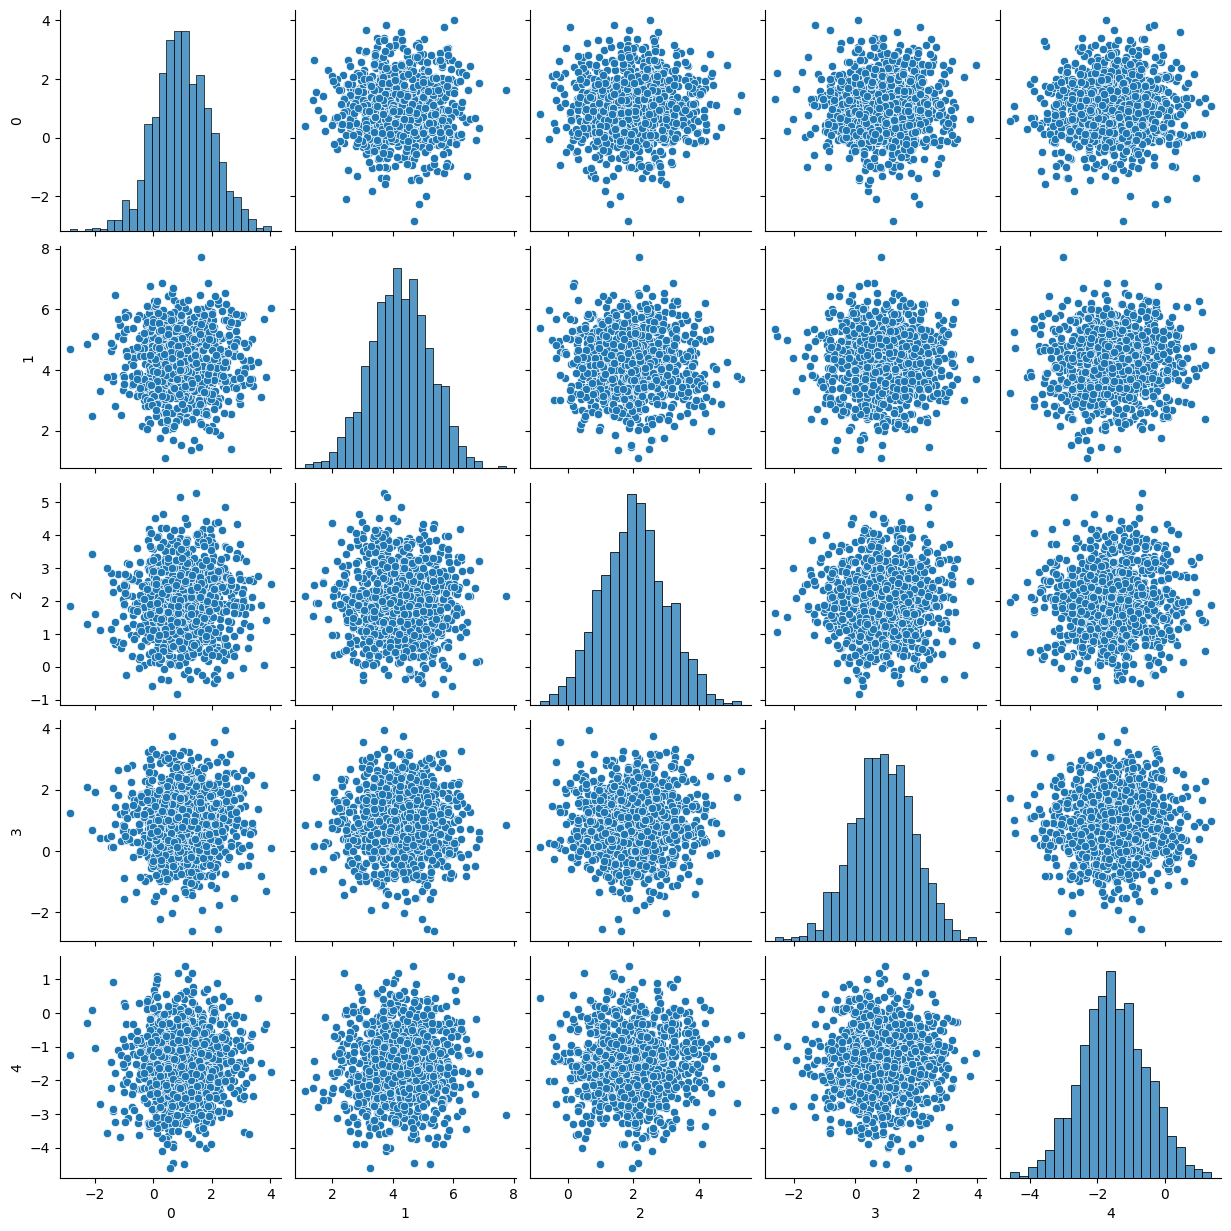

In [27]:
sns.pairplot(df)

In [28]:
params = {'weights':gmm.weights_, 'means':gmm.means_, 'covs':gmm.covariances_}

In [29]:
structure ={'V':['x1','x2','x3','x4','x5'], 'E':[('x1','x2'),('x1','x3'),('x1','x4'),('x1','x5'), ('x2','x5'), ('x3','x5'), ('x4','x2')]}


In [30]:
bn_model = BNGenerator(bn_structure=structure, n_components=3, gmm_parameters=params)
sample = bn_model.get_sample(1000)
sample

2023-04-28 14:23:28,347 | INFO     | preprocessors.py-scan-0099 | No one column is discrete


100%|██████████| 1000/1000 [00:02<00:00, 494.49it/s]


,x1,x3,x4,x2,x5
0,1.099119,2.650012,-0.459965,3.305503,-0.488603
1,0.281992,1.984753,2.101161,3.443491,-0.741865
2,0.778858,2.016876,2.265890,3.424315,-1.950487
3,-0.463493,0.994703,1.734834,5.102354,-2.087743
4,1.000725,0.732081,2.676660,5.932498,-0.970564
...,...,...,...,...,...
995,2.025434,1.322299,1.145073,4.396705,-1.779594
996,1.865753,2.134938,1.805927,2.093384,-2.220475
997,1.889182,2.477349,-0.201765,4.522344,-3.256805
998,0.084905,2.459539,-0.122812,5.734904,-1.244907


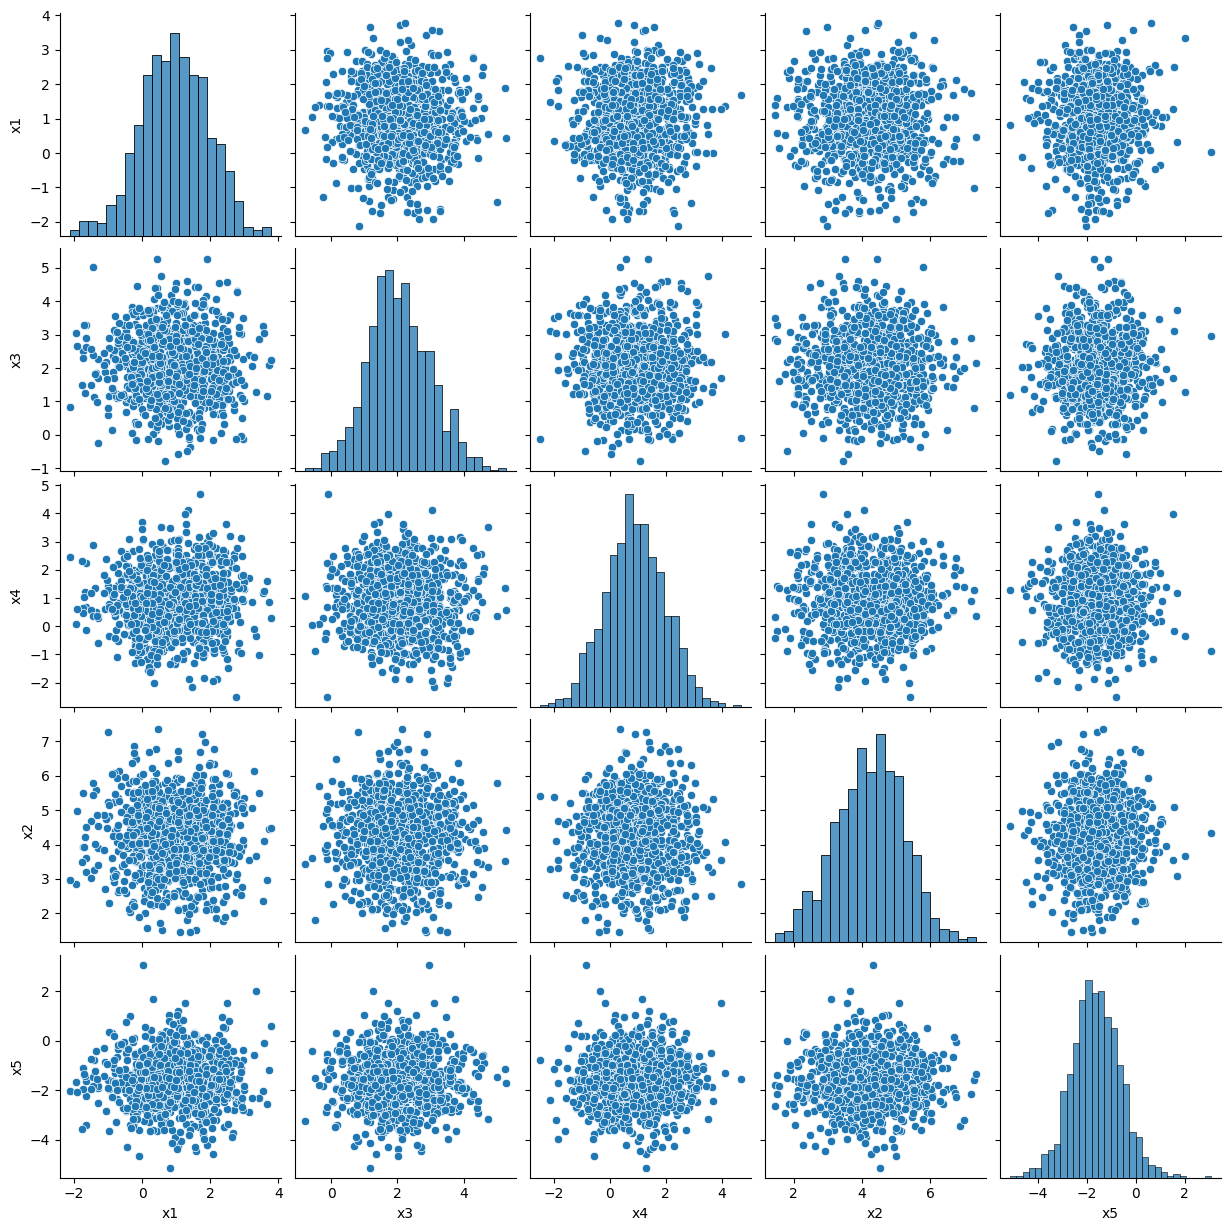

In [31]:
sns.pairplot(sample)